# Google Stock Prediction


In [40]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

init_df = pd.read_csv('./dataset/GOOGL.csv')

print(init_df.head())

         Date       Open       High        Low      Close  Adj Close    Volume
0  2004-08-19  50.050049  52.082081  48.028027  50.220219  50.220219  44659096
1  2004-08-20  50.555557  54.594597  50.300301  54.209209  54.209209  22834343
2  2004-08-23  55.430431  56.796799  54.579578  54.754753  54.754753  18256126
3  2004-08-24  55.675674  55.855858  51.836838  52.487488  52.487488  15247337
4  2004-08-25  52.532532  54.054054  51.991993  53.053055  53.053055   9188602


### Clean Up the dataframe

In [41]:
df = init_df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.loc[:, 'HL_percent'] = (df['High'] - df['Close']) / df['Close'] * 100
df.loc[:, 'Percent_change'] = (df['Close'] - df['Open']) / df['Open'] * 100

df = df[['Close', 'HL_percent', 'Percent_change', 'Volume']]

print(df.head())

       Close  HL_percent  Percent_change    Volume
0  50.220219    3.707395        0.340000  44659096
1  54.209209    0.710927        7.227004  22834343
2  54.754753    3.729441       -1.218966  18256126
3  52.487488    6.417472       -5.726354  15247337
4  53.053055    1.886789        0.990858   9188602


/var/folders/ts/pq8sjrwd5ng7g3fpjdp_17t80000gn/T/ipykernel_89294/1821963255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'HL_percent'] = (df['High'] - df['Close']) / df['Close'] * 100


### ADD LABEL COLUMN

In [42]:
import math

FORECAST_COL = 'Close'
df.fillna(-9999, inplace=True)

# forecast future close based on today features
FORECAST_OUT = int(math.ceil(0.01*len(df)))

LABEL = 'Future_close'
df[LABEL] = df[FORECAST_COL].shift(-FORECAST_OUT)
init_df[LABEL] = init_df[FORECAST_COL].shift(-FORECAST_OUT)
df.dropna(inplace=True)
print(df.head())

       Close  HL_percent  Percent_change    Volume  Future_close
0  50.220219    3.707395        0.340000  44659096     86.301300
1  54.209209    0.710927        7.227004  22834343     93.793793
2  54.754753    3.729441       -1.218966  18256126     90.990990
3  52.487488    6.417472       -5.726354  15247337     93.078079
4  53.053055    1.886789        0.990858   9188602     96.746750


### Prepare data

In [43]:
# Define features and labels
print(df.columns)
X = np.array(df.drop(LABEL, axis=1))
y = np.array(df[LABEL])

# Scaling the features
X = preprocessing.scale(X)

# Getting data without label for prediction testing
X_lately = X[-FORECAST_OUT:]

# create training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

Index(['Close', 'HL_percent', 'Percent_change', 'Volume', 'Future_close'], dtype='object')


### Prepare Classifier ( Linear Regression )

In [44]:
clf_LR = LinearRegression()
clf_LR.fit(X_train, y_train)
accuracy_LR = clf_LR.score(X_test, y_test)

print(f"Accuracy Linear Regression : {accuracy_LR}\n\n")

Accuracy Linear Regression : 0.9842330510416987




### Prepare Classifier ( SVM ) -- Default

In [45]:
clf_SVM_L = svm.SVR()
clf_SVM_L.fit(X_train, y_train)
accuracy_SVM_L = clf_SVM_L.score(X_test, y_test)

print(f"Accuracy SVM Linear : {accuracy_SVM_L}\n\n")

Accuracy SVM Linear : 0.4112578763908237




### Prepare Classifier ( SVM ) -- Polynomial

In [46]:
clf_SVM_P = svm.SVR(kernel='poly')
clf_SVM_P.fit(X_train, y_train)
accuracy_SVM_P = clf_SVM_P.score(X_test, y_test)

print(f"Accuracy SVM Polynomial : {accuracy_SVM_P}\n\n")

Accuracy SVM Polynomial : 0.6640329740428457




In [47]:
def get_classifier_prediction(clf, data):
    return clf.predict(data)

In [48]:
def plot_prediction(forecast_set, classifier, accuracy):
    prediction_df = init_df.copy()
    prediction_df.loc[prediction_df.index[-FORECAST_OUT:], LABEL] = forecast_set

    prediction_df.loc[:, 'Date'] = pd.to_datetime(prediction_df['Date'])  # Convert 'Date' column to datetime type
    prediction_df.loc[:, 'prediction_date'] = prediction_df['Date'] + pd.DateOffset(days=FORECAST_OUT)
    
    
    plt.figure(figsize=(12, 6))
    plt.plot(prediction_df['prediction_date'], prediction_df[LABEL])
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(f'Graph of Google Close Stock Price over Time BY {classifier}, Accuracy : {accuracy}')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.show()


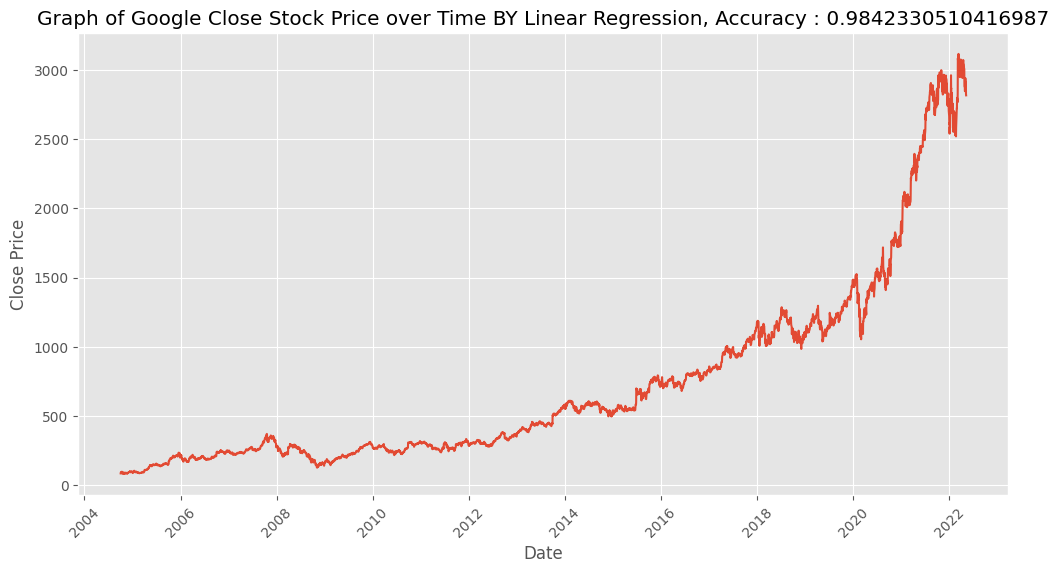

In [49]:
plot_prediction(get_classifier_prediction(clf_LR, X_lately),"Linear Regression", accuracy_LR)

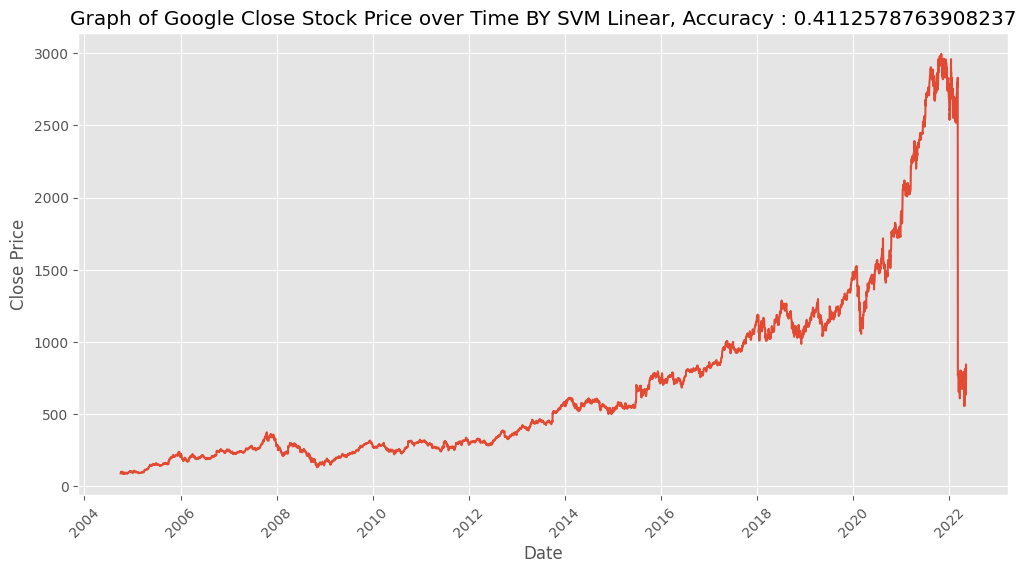

In [50]:
plot_prediction(get_classifier_prediction(clf_SVM_L, X_lately),"SVM Linear", accuracy_SVM_L)

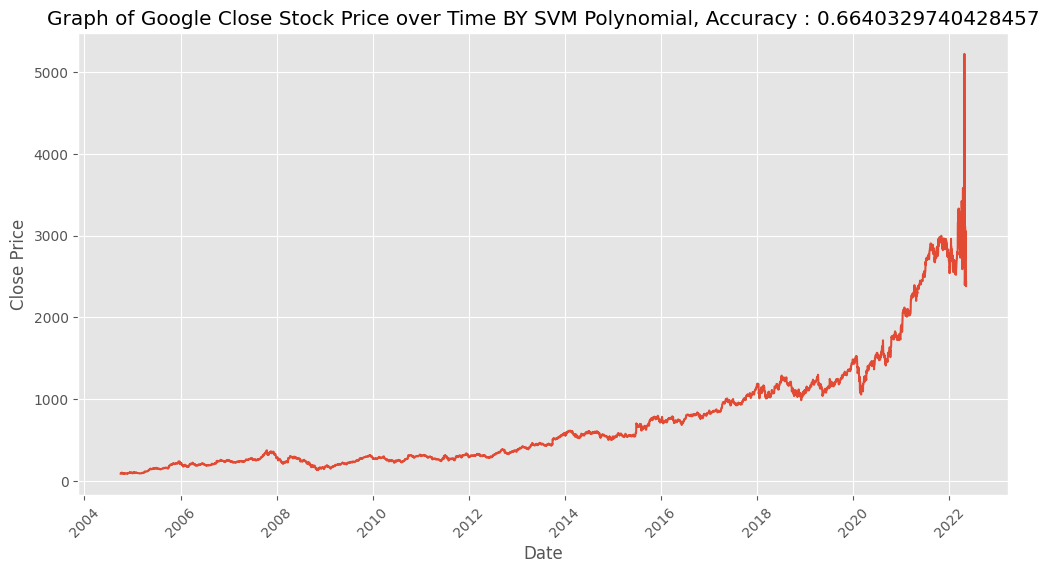

In [51]:
plot_prediction(get_classifier_prediction(clf_SVM_P, X_lately),"SVM Polynomial", accuracy_SVM_P)

### Pickling the models

In [52]:
import pickle
for cls in [[clf_LR, 'LinearRegression'], [clf_SVM_L, 'SVM_Linear'], [clf_SVM_P, 'SVM_Polynomial']]:
    with open(f'./models/{cls[1]}.pickle', 'wb') as f:
        pickle.dump(cls[0], f)
        f.close()

### Reuse pickled model

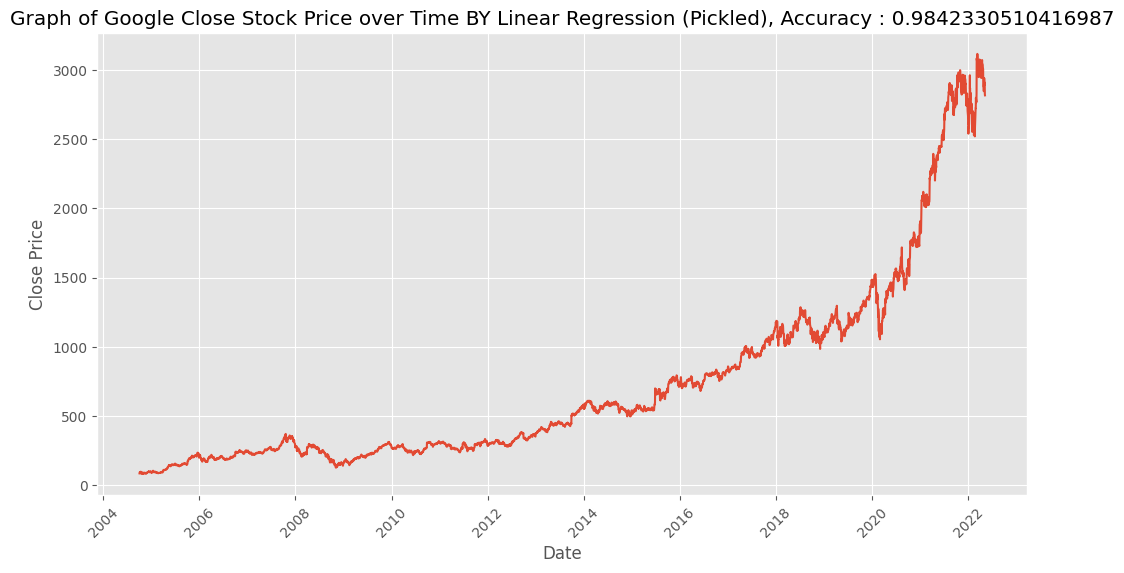

In [53]:
pickle_in = open('./models/LinearRegression.pickle', 'rb')
clf = pickle.load(pickle_in)
plot_prediction(get_classifier_prediction(clf, X_lately),"Linear Regression (Pickled)", accuracy_LR)